# 🛍️ SmartCart Starter Notebook
This notebook will guide you through your group project on collaborative filtering and association rule mining for an e-commerce recommender system.

## 📥 Part 1: Data Preprocessing
Steps:
- Load `ecommerce_user_data.csv` and `product_details.csv`
- Merge data if necessary
- Create user-item matrix
- Fill missing ratings with 0
- Group user behavior by category

In [1]:
# Load data
import pandas as pd

user_data = pd.read_csv('ecommerce_user_data.csv')
product_data = pd.read_csv('product_details.csv')

print("User data header:\n\n",user_data.head())
print("\n\nProduct data header:\n\n",product_data.head(),"\n\n")
print("Check for null values for User data:\n\n",user_data.isnull().any(),"\n\n")
print("Check for null values for product data\n\n", product_data.isnull().any())

User data header:

   UserID ProductID  Rating   Timestamp  Category
0   U000     P0009       5  2024-09-08     Books
1   U000     P0020       1  2024-09-02      Home
2   U000     P0012       4  2024-10-18     Books
3   U000     P0013       1  2024-09-18  Clothing
4   U000     P0070       4  2024-09-16      Toys


Product data header:

   ProductID      ProductName     Category
0     P0000      Toys Item 0     Clothing
1     P0001  Clothing Item 1  Electronics
2     P0002     Books Item 2  Electronics
3     P0003  Clothing Item 3  Electronics
4     P0004  Clothing Item 4  Electronics 


Check for null values for User data:

 UserID       False
ProductID    False
Rating       False
Timestamp    False
Category     False
dtype: bool 


Check for null values for product data

 ProductID      False
ProductName    False
Category       False
dtype: bool


In [ ]:
# Rename 'Category' in product_data to avoid conflict during merge
product_data = product_data.rename(columns={'Category': 'ProductCategory'}) #we have 'Category' in both files, we need to differentiate them

# Merge datasets
merged_data = pd.merge(user_data, product_data, on='ProductID', how='left') #combining datasets based on common factor, which is 'ProductID'

# Confirm column names after merge
print(merged_data.columns.tolist())
# Output should be: ['UserID', 'ProductID', 'Rating', 'Timestamp', 'Category', 'ProductName', 'ProductCategory']

# Group by user and their original interaction category (from user_data)
user_category_agg = merged_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']

# Preview the result
print(user_category_agg.head())

#the goal is here is to capture and quantify user preferences at the category level.
#eg: U000 seems to really like toys and books due to number of interactions and average ratings.

['UserID', 'ProductID', 'Rating', 'Timestamp', 'Category', 'ProductName', 'ProductCategory']
  UserID     Category  TotalInteractions  AverageRating
0   U000        Books                  6       3.666667
1   U000     Clothing                  3       1.666667
2   U000  Electronics                  3       3.666667
3   U000         Home                  2       1.000000
4   U000         Toys                  6       3.500000


In [ ]:
# Create user-item matrix using merged_data for consistency
user_item_matrix = merged_data.pivot_table(index='UserID', columns='ProductID', values='Rating')
user_item_matrix_filled = user_item_matrix.fillna(0)
print(user_item_matrix_filled.head())

#rating of all products by each user. NaN are replaced with 0.

ProductID  P0000  P0001  P0002  P0003  P0004  P0005  P0006  P0007  P0008  \
UserID                                                                     
U000         0.0    0.0    0.0    3.0    0.0    5.0    0.0    3.0    0.0   
U001         0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0   
U002         0.0    0.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0   
U003         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U004         0.0    3.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0   

ProductID  P0009  ...  P0090  P0091  P0092  P0093  P0094  P0095  P0096  P0097  \
UserID            ...                                                           
U000         5.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U001         0.0  ...    0.0    5.0    0.0    0.0    0.0    3.0    0.0    0.0   
U002         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
U003         0.0  ...    0.0    0.0    0.0    0.0    0.0    0.

In [ ]:
# Aggregate user behavior by interaction category (from user_data)
user_category_agg = merged_data.groupby(['UserID', 'Category']).agg({'Rating': ['count', 'mean']}).reset_index()
user_category_agg.columns = ['UserID', 'Category', 'TotalInteractions', 'AverageRating']
print(user_category_agg.head())


#duplicate lol

  UserID     Category  TotalInteractions  AverageRating
0   U000        Books                  6       3.666667
1   U000     Clothing                  3       1.666667
2   U000  Electronics                  3       3.666667
3   U000         Home                  2       1.000000
4   U000         Toys                  6       3.500000


## 🤝 Part 2: User-Based Collaborative Filtering
Steps:
- Use cosine similarity to compare users
- Recommend top-N products based on similar users
- Evaluate with Precision@K and Coverage

In [ ]:
# Compute cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_matrix_filled)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix_filled.index, columns=user_item_matrix_filled.index)
similarity_df.head()

#comparing similarities with other users

UserID,U000,U001,U002,U003,U004,U005,U006,U007,U008,U009,...,U040,U041,U042,U043,U044,U045,U046,U047,U048,U049
UserID,,,,,,,,,,,,,,,,,,,,,
U000,1.000000,0.063071,0.195522,0.023466,0.065412,0.161251,0.160096,0.092083,0.238263,0.274844,...,0.241693,0.129483,0.156790,0.132200,0.161478,0.100346,0.126917,0.150727,0.000000,0.104294
U001,0.063071,1.000000,0.190861,0.000000,0.111332,0.009540,0.000000,0.172286,0.167460,0.017593,...,0.121540,0.024075,0.097953,0.007821,0.000000,0.000000,0.193670,0.247805,0.000000,0.000000
U002,0.195522,0.190861,1.000000,0.065094,0.111662,0.050830,0.027756,0.055877,0.000000,0.181229,...,0.144756,0.000000,0.217465,0.000000,0.055992,0.034794,0.194243,0.110030,0.177165,0.000000
U003,0.023466,0.000000,0.065094,1.000000,0.035737,0.104116,0.026650,0.000000,0.025384,0.288009,...,0.243836,0.000000,0.000000,0.074688,0.197121,0.000000,0.054396,0.126773,0.374228,0.250000
U004,0.065412,0.111332,0.111662,0.035737,1.000000,0.159064,0.057144,0.026294,0.195942,0.247023,...,0.062741,0.116202,0.078797,0.048044,0.103747,0.133716,0.124969,0.217464,0.255318,0.172729


In [6]:
# Create a recommendation function
# Find the most similar user, recommend products they rated highly that the target user hasn’t rated

n_top = 10 #number of recommendations

def recommend_products(user_id, similarity_df, user_item_matrix,user_category_agg ,top_n = 10):
    similar_users = similarity_df[user_id].sort_values(ascending=False).index[1:]

    preferred_categories = user_category_agg[user_category_agg['UserID'] == user_id].sort_values(by='AverageRating', ascending=False)['Category'].tolist()

    recommended_products = []

    seen_products = set(user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index)

    for similar_user in similar_users:
        user_interactions = user_item_matrix.loc[similar_user]
        unseen_products = user_interactions[user_interactions > 0].index.difference(seen_products)
        recommended_products.extend(unseen_products)

        if len(recommended_products)>10:
            break

    return recommended_products[:top_n]

#Sample test:
user_id = "U001"
recommended_products = recommend_products(user_id, similarity_df,user_item_matrix_filled,user_category_agg )
print(f"Recommended products for {user_id}: {recommended_products}") 

Recommended products for U001: ['P0007', 'P0008', 'P0010', 'P0015', 'P0025', 'P0046', 'P0061', 'P0064', 'P0067', 'P0074']


### Evaluation Metrics Formulas:
Precision@K
$$
\text{Precision@K} = \frac{\text{Number of Relevant Items in Top K}}{K}
$$
Recall@K
$$
\text{Recall@K} = \frac{\text{Number of Relevant Items in Top K}}{\text{Total Number of Relevant Items}}
$$
Mean Average Precision (MAP)
$$
\text{MAP} = \frac{1}{N} \sum_{u=1}^{N} \frac{\sum_{k=1}^{K} P(k) \cdot \text{Rel}(k)}{\text{Total Relevant Items}}
$$
Coverage
$$
\text{Coverage} = \frac{\text{Number of Unique Items Recommended}}{\text{Total Number of Available Items}}
$$
Diversity
$$
\text{Diversity} = 1 - \frac{\sum_{u=1}^{N} \sum_{v=1}^{N} S(u, v)}{N \cdot (N-1)}
$$


In [7]:
# Implement evaluation metrics like Precision@K and Coverage
# Example: compare recommended vs actual rated items

def precision_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_at_k = len(set(recommended_at_k) & set(relevant_items))
    return relevant_at_k / k

def recall_at_k(recommended_items, relevant_items, k):
    recommended_at_k = recommended_items[:k]
    relevant_at_k = len(set(recommended_at_k) & set(relevant_items))
    return relevant_at_k / len(relevant_items) if len(relevant_items) > 0 else 0

def average_precision(recommended_items, relevant_items):
    if not relevant_items:
        return 0
    score = 0.0
    num_hits = 0.0
    for i, item in enumerate(recommended_items):
        if item in relevant_items:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / max(1, len(relevant_items))

def mean_average_precision(all_recommendations, all_relevant_items):
    return np.mean([average_precision(recommended, relevant) 
                    for recommended, relevant in zip(all_recommendations, all_relevant_items)])

n_top = 10
all_recommendations = []
all_relevant_items = []

for user_id in user_item_matrix_filled.index:
    recommended_products = recommend_products(user_id, similarity_df, user_item_matrix, user_category_agg, n_top)
    all_recommendations.append(recommended_products)

    relevant_items = set(user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index)
    all_relevant_items.append(list(relevant_items))


In [8]:
import numpy as np
#Evaluation:
k = 10
precision_scores = []
recall_scores = []

for recommended, relevant in zip(all_recommendations, all_relevant_items):
    precision_scores.append(precision_at_k(recommended, relevant, k))
    recall_scores.append(recall_at_k(recommended, relevant, k))

print(f"Precision@{k}: {np.mean(precision_scores):.4f}")
print(f"Recall@{k}: {np.mean(recall_scores):.4f}")

# Calculate MAP
map_score = mean_average_precision(all_recommendations, all_relevant_items)
print(f"Mean Average Precision (MAP): {map_score:.4f}")


Precision@10: 0.0000
Recall@10: 0.0000
Mean Average Precision (MAP): 0.0000


## 🔍 Part 3: Association Rule Mining (Apriori)
Steps:
- Convert user-product interactions to transaction format
- Apply Apriori algorithm to find frequent itemsets
- Generate association rules (support, confidence, lift)

In [ ]:
# # Convert to transaction format
# from mlxtend.preprocessing import TransactionEncoder
# transactions = user_data.groupby('UserID')['ProductID'].apply(list).tolist()
# te = TransactionEncoder()
# te_ary = te.fit(transactions).transform(transactions)
# df_trans = pd.DataFrame(te_ary, columns=te.columns_)

Sample transactions:
User 1 purchased: ['P0009', 'P0020', 'P0012', 'P0013', 'P0070', 'P0014', 'P0048', 'P0079', 'P0042', 'P0050', 'P0046', 'P0021', 'P0028', 'P0047', 'P0005', 'P0003', 'P0007', 'P0071', 'P0044', 'P0033']
User 2 purchased: ['P0051', 'P0055', 'P0095', 'P0033', 'P0002', 'P0054', 'P0050', 'P0020', 'P0091', 'P0086', 'P0030', 'P0044', 'P0037']
User 3 purchased: ['P0083', 'P0081', 'P0020', 'P0005', 'P0049', 'P0071', 'P0054', 'P0086', 'P0014', 'P0067', 'P0059', 'P0052', 'P0085', 'P0072']

Transaction matrix shape: (50, 100)
First few columns: Index(['P0000', 'P0001', 'P0002', 'P0003', 'P0004'], dtype='object')

Frequent itemsets:
    support itemsets  length
69     0.34  (P0070)       1
88     0.26  (P0089)       1
50     0.26  (P0051)       1
87     0.24  (P0088)       1
42     0.24  (P0043)       1
29     0.22  (P0030)       1
43     0.22  (P0044)       1
64     0.22  (P0065)       1
4      0.22  (P0004)       1
76     0.22  (P0077)       1

Top Association Rules:
        ant

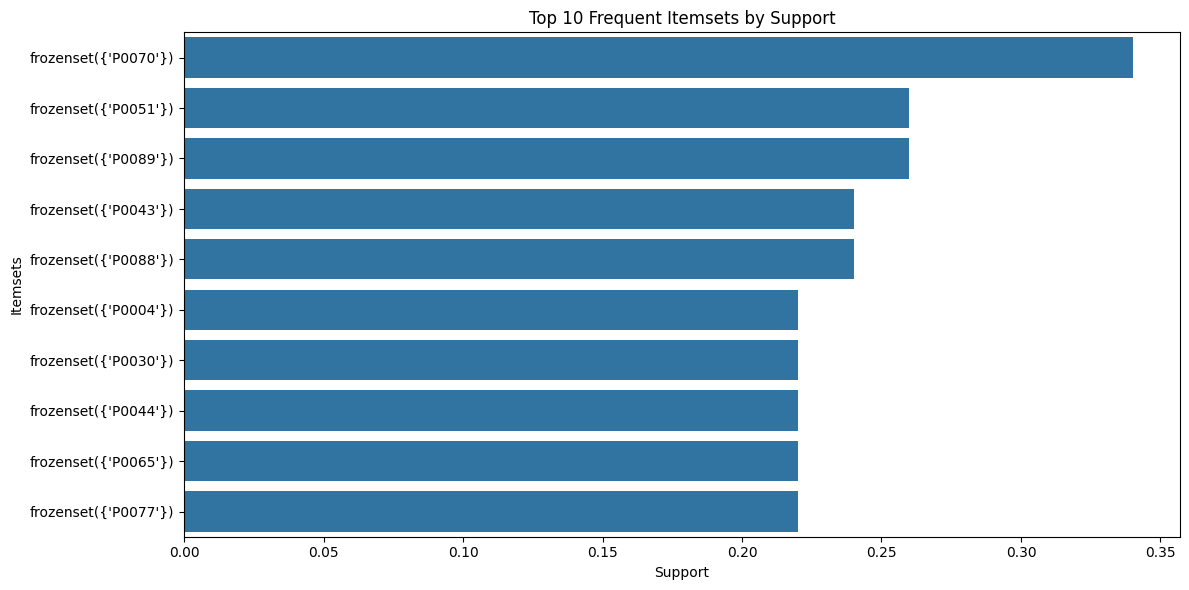

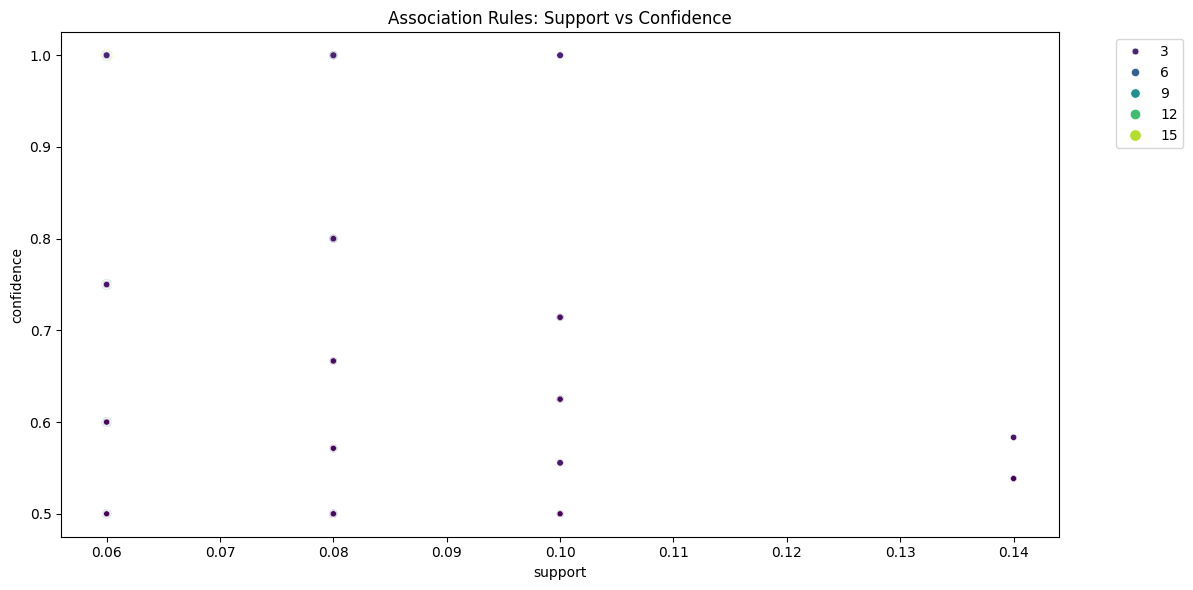

C:\Users\vicki\AppData\Local\Temp\ipykernel_27356\131084886.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


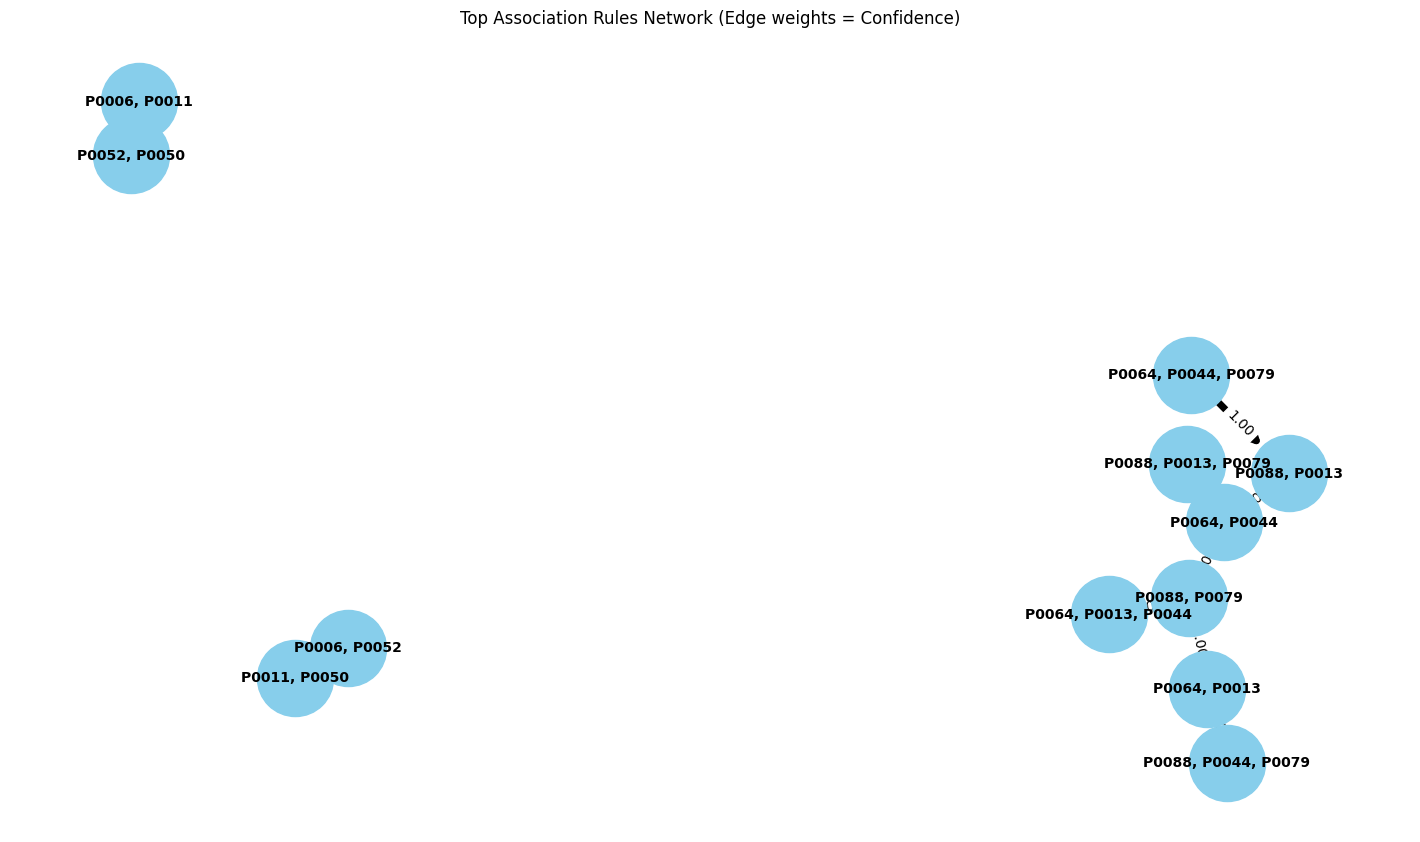

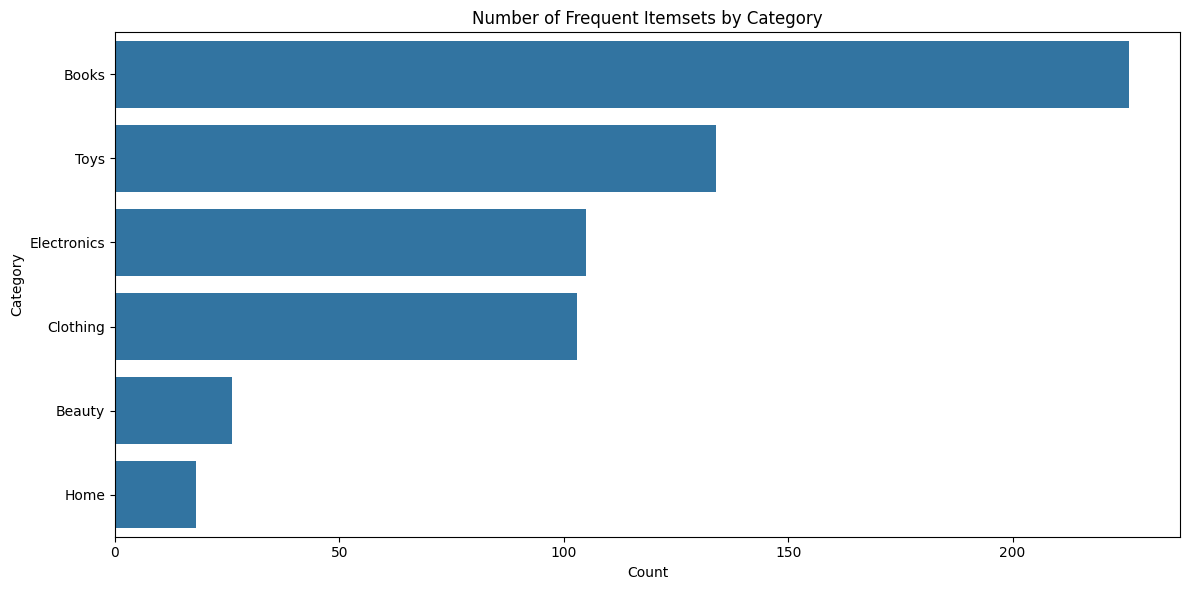

In [14]:
# First, let's prepare the transaction data for Apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Convert the merged data into transactions (list of products purchased by each user)
transactions = merged_data.groupby('UserID')['ProductID'].apply(list).values.tolist()

# Preview the first few transactions
print("Sample transactions:")
for i, transaction in enumerate(transactions[:3]):
    print(f"User {i+1} purchased: {transaction}")

# Convert transactions to one-hot encoded format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

print("\nTransaction matrix shape:", transaction_df.shape)
print("First few columns:", transaction_df.columns[:5])

# Find frequent itemsets using Apriori algorithm
# Adjust min_support based on your data size (lower for more itemsets)
frequent_itemsets = apriori(transaction_df, min_support=0.05, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

print("\nFrequent itemsets:")
print(frequent_itemsets.sort_values('support', ascending=False).head(10))

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Filter rules to only show those with lift > 1 (meaningful associations)
strong_rules = rules[rules['lift'] > 1]

# Sort by confidence and lift
strong_rules = strong_rules.sort_values(['confidence', 'lift'], ascending=False)

print("\nTop Association Rules:")
print(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Visualization of frequent itemsets
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='support', y='itemsets', 
            data=frequent_itemsets.nlargest(10, 'support'))
plt.title('Top 10 Frequent Itemsets by Support')
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.tight_layout()
plt.show()

# Visualization of association rules
plt.figure(figsize=(12, 6))
sns.scatterplot(data=strong_rules, x='support', y='confidence', 
                size='lift', hue='lift', palette='viridis')
plt.title('Association Rules: Support vs Confidence')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Network visualization of top rules
import networkx as nx

plt.figure(figsize=(14, 8))
G = nx.DiGraph()

# Add edges with weights based on confidence
for _, row in strong_rules.head(15).iterrows():
    antecedents = ', '.join(list(row['antecedents']))
    consequents = ', '.join(list(row['consequents']))
    G.add_edge(antecedents, consequents, weight=row['confidence']*10)

pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G, pos, with_labels=True, 
        node_size=3000, 
        node_color='skyblue', 
        font_size=10, 
        font_weight='bold',
        width=[d['weight']*0.5 for (u, v, d) in G.edges(data=True)])
edge_labels = {(u, v): f"{d['weight']/10:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Top Association Rules Network (Edge weights = Confidence)')
plt.tight_layout()
plt.show()

# Additional analysis: Frequent itemsets by category
# First, let's create a mapping of product to category
product_category_map = merged_data[['ProductID', 'Category']].drop_duplicates().set_index('ProductID')['Category']

# Function to get the most common category in an itemset
def get_main_category(itemset):
    categories = [product_category_map[product] for product in itemset]
    return max(set(categories), key=categories.count)

# Add category information to frequent itemsets
frequent_itemsets['main_category'] = frequent_itemsets['itemsets'].apply(get_main_category)

# Plot frequent itemsets by category
plt.figure(figsize=(12, 6))
category_counts = frequent_itemsets.groupby('main_category').size().sort_values(ascending=False)
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('Number of Frequent Itemsets by Category')
plt.xlabel('Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [ ]:
# # Apply Apriori and generate rules
# from mlxtend.frequent_patterns import apriori, association_rules
# frequent_itemsets = apriori(df_trans, min_support=0.05, use_colnames=True)
# rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)
# rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head()

,antecedents,consequents,support,confidence,lift
0,(P0000),(P0008),0.06,0.500000,2.777778
1,(P0000),(P0023),0.06,0.500000,3.125000
2,(P0000),(P0030),0.06,0.500000,2.272727
3,(P0000),(P0071),0.06,0.500000,2.777778
4,(P0091),(P0001),0.08,0.571429,3.174603


## 📊 Part 4: Visualization
Steps:
- Plot user similarity heatmap
- Plot top frequent itemsets
- Visualize top recommendations

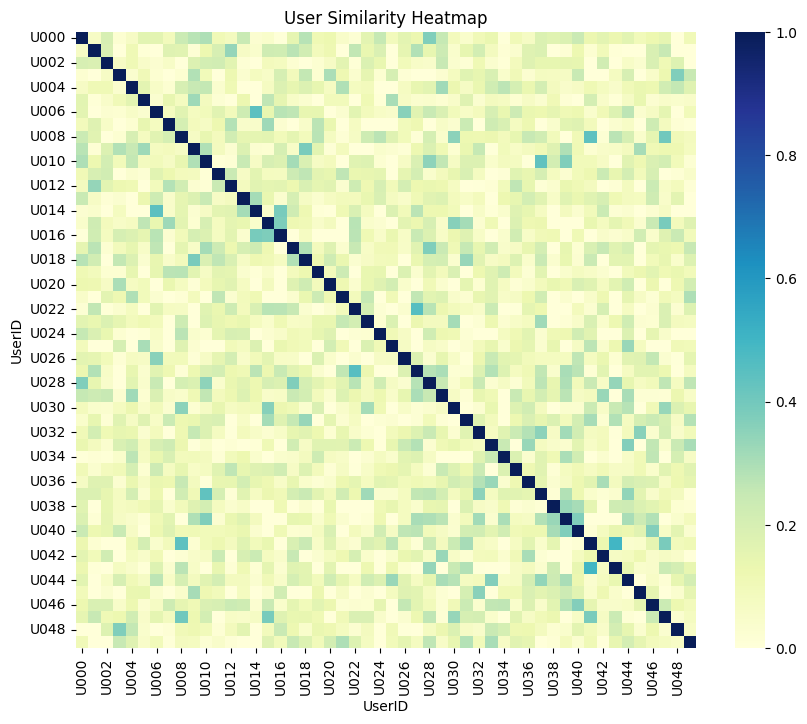

In [12]:
# Heatmap of user similarity
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, cmap='YlGnBu')
plt.title('User Similarity Heatmap')
plt.show()

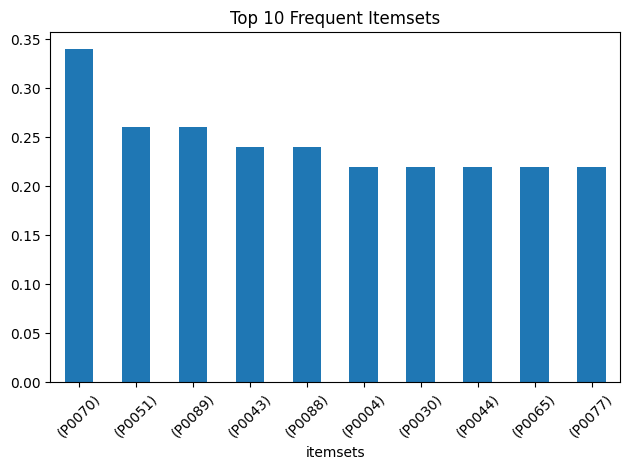

In [13]:
# Frequent itemsets bar chart
frequent_itemsets.nlargest(10, 'support').plot(kind='bar', x='itemsets', y='support', legend=False)
plt.title('Top 10 Frequent Itemsets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 🧠 Part 5: Conceptual Questions
Answer the following questions in your report:
1. How does data sparsity affect performance?
2. What kinds of product bundles were discovered?
3. What improvements would you suggest for real-world deployment?